# Alignment of 3k PBMCs against ELDB.v20221214 - AWS
v2023-11-15

In [4]:
# delete the output to reset the tutorials
!rm -rf output/pbmc3k.combined_with_eldb.v20221214.aws.subset_320000.ram/

In [1]:
# not use GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# import scelephant
import scelephant as el
from scelephant import RamData
import scanpy as sc

# plotly export settings
import plotly.io as pio
pio.renderers.default = "notebook"

"""
configure the jupyter notebook environment
"""
el.bk.Wide( 100 ) # adjust the jupyter notebook cell width 

import matplotlib as mpl
mpl.rcParams[ "figure.dpi" ] = 100
# set image resolution

# load memory profiler 
# %load_ext memory_profiler

In [5]:
# initialize a pool of managed operators
fop = el.managers.FileSystemOperatorPool( 8 ) # this pool of managed operators will be used throughout the tutorials

# ram_ref = RamData( 's3://scelephant-free/ELDB.combined_v20221214.subset_320000_barcodes.ramdata/', file_system_operator_pool = fop, name_layer = None ) # contain full ELDB data, but it is requester-pay bucket, and it is not FREE
ram_ref = RamData( '/home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/no_scarab/ELDB.combined_v20221214.subset_320000_barcodes.ramdata/', file_system_operator_pool = fop, name_layer = None ) # contain full ELDB data, but it is requester-pay bucket, and it is not FREE
# ram_ref = RamData( 's3://scelephant/ELDB.combined_v20221214.ramdata/', file_system_operator_pool = fop, name_layer = None ) # contain full ELDB data, but it is requester-pay bucket, and it is not FREE
ram_query = RamData( f'output/pbmc3k.ram/', file_system_operator_pool = fop )

# build feature mapping using 'id_gene', not 'name_gene'
ram_ref.ft.int_index_str_rep = 0
ram_query.ft.int_index_str_rep = 0

ram = RamData(
    "output/pbmc3k.combined_with_eldb.v20221214.aws.subset_320000.ram/",
    l_ramdata = [ ram_ref, ram_query ],
    name_layer = None,
    int_total_weight_for_each_batch = 10_000_000,
    int_index_component_reference = 0,
    file_system_operator_pool = fop,
)

2023-11-17 23:18:12,391 [SC-Elephant] <INFO> (layer) - 'raw' layer has been loaded


In [6]:
# settings of the pipeline
l_anno_ori = [ 'leiden_scanpy' ]
flag_copy_pca_values = False # copy pca values of the reference database

In [7]:
"""
Get PCA values of the new barcodes
"""
name_col_bc_all = 'filtered_barcodes'

name_col_filter_ft = "filter_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp"
ram.ft.change_filter( name_col_filter_ft )

# create umap from scelephant-DB (Hs) using genes from which DEGs between data sources are removed
int_num_barcodes_in_pumap_batch = 10000000
int_num_barcodes_for_a_batch = 250000
float_prop_subsampling_pca = 1

# set the suffix of the run
name_model = 'ipca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp'

str_suffix_new = '_aligned'
str_suffix = '_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp'
name_col_pca = f'X_pca{str_suffix}{str_suffix_new}'

"""
Get PCA values
"""
model = ram.apply_pca( 
    name_model = f'ipca{str_suffix}', 
    name_layer = 'normalized_log1p_capped', 
    name_col = name_col_pca, 
    name_col_filter = f'filter_pca{str_suffix}{str_suffix_new}', 
    int_n_components_in_a_chunk = 20, 
    int_num_threads = 5,
    int_index_component_reference = 0,
)

2023-11-17 23:18:16,896 [SC-Elephant] <INFO> (layer) - loading a layer 'normalized_log1p_capped' of RamData component 0
2023-11-17 23:18:17,152 [SC-Elephant] <INFO> (layer) - 'normalized_log1p_capped' layer has been loaded
2023-11-17 23:18:17,154 [SC-Elephant] <INFO> (layer) - loading a layer 'normalized_log1p_capped' of RamData component 1
2023-11-17 23:18:17,209 [SC-Elephant] <INFO> (layer) - 'normalized_log1p_capped' layer has been loaded
2023-11-17 23:18:17,879 [SC-Elephant] <INFO> (layer) - 'normalized_log1p_capped' layer has been loaded
100 PCs from 10504 features: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169867800/169867800 [00:09<00:00, 18395838.58it/s]


In [8]:
"""
co-embedding of new barcodes
"""
str_num_subsampled_cells = '160000'
name_model = f"knnindex__filtered_barcodes_subsampled_{str_num_subsampled_cells}_entries_clus_info__X_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp__100comp__30_neighbors"
name_col_filter_bc_subsampled = f'filtered_barcodes_subsampled_{str_num_subsampled_cells}_entries_clus_info'
name_umap = 'X_umap_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_filtered_barcodes_subsampled_18097526_entries_30knn100comp_scanpy_spectral'
name_umap_combined = f'{name_umap}_combined'

ram.bc.change_filter( name_col_filter_bc_subsampled )

ram.bc.meta[ name_umap_combined ] = ram.bc.meta[ name_umap ] # copy original values

# primary & secondary neighbors
ram.bc.change_filter( name_col_bc_all )
ram.apply_knn(
    name_model,
    name_col_x = name_col_pca, 
    name_col_y_input = name_umap,
    name_col_y_output = name_umap_combined,
    axis = 'barcodes',
    operation = 'embedder',
    float_std_ratio_for_outlier_detection = 0.03,
    name_col_filter_neighbors_of_the_query = 'filter_barcodes_aligned',
    int_index_component_reference = 0,
)

# primary neighbors only
ram.bc.change_filter( name_col_bc_all )
ram.apply_knn(
    name_model,
    name_col_x = name_col_pca, 
    name_col_y_input = name_umap,
    name_col_y_output = name_umap_combined,
    axis = 'barcodes',
    operation = 'embedder',
    float_std_ratio_for_outlier_detection = 0.03,
    name_col_filter_neighbors_of_the_query = 'filter_barcodes_aligned_primary',
    flag_include_secondary_neighbors_of_the_query = False,
    int_index_component_reference = 0,
)

2023-11-17 23:18:46,173 [root] <INFO> (apply_knn) - [Info] [RamData.apply_label] the nearest-neighbor search started
2023-11-17 23:18:46,175 [SC-Elephant] <INFO> (apply_knn) - Starting kNN-based embedder operation using 8880 entries in the index
embedder using 8880 entries: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:01<00:00, 1733.73it/s]
2023-11-17 23:18:51,175 [root] <INFO> (apply_knn) - [Info] [RamData.apply_label] the nearest-neighbor search started
2023-11-17 23:18:51,177 [SC-Elephant] <INFO> (apply_knn) - Starting kNN-based embedder operation using 8880 entries in the index
embedder using 8880 entries: 100%|████████████████████████████████████████████████

In [9]:
"""
predict annotations
"""
for resol in [ 0.1, 0.5, 1, 2, 5, 10, 20, 30 ] :
    name_anno_combined = f'annotation_label_predicted_resol_{resol}'
    name_anno = f'annotated_leiden_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_filtered_barcodes_subsampled_10857942_entries_30knn100comp_scanpy__resolution_{resol}_based_on_cellmarker2db'
    
    # copy original values
    ram.bc.filter = None # copy all values without lazy loading
    ram.bc.meta[ name_anno_combined ] = ram.bc.meta[ name_anno ] # copy original values
    
    ram.bc.filter = ram.bc.select_component( 1 ) & ram.bc.get_filter( name_col_bc_all ) # select the component 1
    ram.apply_dl( 
        name_model = f'dl_model_X_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_annotated_leiden_10857942_entries_30knn100comp_scanpy__resolution_{resol}_based_on_cellmarker2db',
        name_col_x = name_col_pca, 
        name_col_y = name_anno_combined,
        operation = 'classifier', 
        flag_apply_to_entries_used_for_training = True, 
        int_num_entries_in_a_batch = 500000, 
        int_num_threads = 5
    )

2023-11-17 23:18:56.022446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 23:18:56.203778: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-17 23:18:56.238809: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 23:18:57.040261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

85/85 [==============================] - 1s 2ms/step


deep-learning classifier: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:01<00:00, 2338.20it/s]
2023-11-17 23:19:03,767 [SC-Elephant] <INFO> (save_model) - dl_model_X_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_annotated_leiden_10857942_entries_30knn100comp_scanpy__resolution_0.5_based_on_cellmarker2db|deep_learning.keras.classifier model saved.
2023-11-17 23:19:03,786 [SC-Elephant] <INFO> (apply_dl) - [RamData.apply_dl] applying deep-learning model started
deep-learning classifier:   0%|                                                                                                                                    

85/85 [==============================] - 0s 2ms/step


deep-learning classifier: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:00<00:00, 2837.22it/s]
2023-11-17 23:19:08,635 [SC-Elephant] <INFO> (save_model) - dl_model_X_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_annotated_leiden_10857942_entries_30knn100comp_scanpy__resolution_1_based_on_cellmarker2db|deep_learning.keras.classifier model saved.
2023-11-17 23:19:08,649 [SC-Elephant] <INFO> (apply_dl) - [RamData.apply_dl] applying deep-learning model started
deep-learning classifier:   0%|                                                                                                                                      

85/85 [==============================] - 0s 2ms/step


deep-learning classifier: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:00<00:00, 3186.40it/s]
2023-11-17 23:19:13,297 [SC-Elephant] <INFO> (save_model) - dl_model_X_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_annotated_leiden_10857942_entries_30knn100comp_scanpy__resolution_2_based_on_cellmarker2db|deep_learning.keras.classifier model saved.
2023-11-17 23:19:13,317 [SC-Elephant] <INFO> (apply_dl) - [RamData.apply_dl] applying deep-learning model started
deep-learning classifier:   0%|                                                                                                                                      

85/85 [==============================] - 0s 2ms/step


deep-learning classifier: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:00<00:00, 3162.31it/s]
2023-11-17 23:19:18,068 [SC-Elephant] <INFO> (save_model) - dl_model_X_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_annotated_leiden_10857942_entries_30knn100comp_scanpy__resolution_5_based_on_cellmarker2db|deep_learning.keras.classifier model saved.
2023-11-17 23:19:18,088 [SC-Elephant] <INFO> (apply_dl) - [RamData.apply_dl] applying deep-learning model started
deep-learning classifier:   0%|                                                                                                                                      

85/85 [==============================] - 0s 2ms/step


deep-learning classifier: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:00<00:00, 3128.78it/s]
2023-11-17 23:19:22,855 [SC-Elephant] <INFO> (save_model) - dl_model_X_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_annotated_leiden_10857942_entries_30knn100comp_scanpy__resolution_10_based_on_cellmarker2db|deep_learning.keras.classifier model saved.
2023-11-17 23:19:22,868 [SC-Elephant] <INFO> (apply_dl) - [RamData.apply_dl] applying deep-learning model started
deep-learning classifier:   0%|                                                                                                                                     

85/85 [==============================] - 0s 2ms/step


deep-learning classifier: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:00<00:00, 3150.23it/s]
2023-11-17 23:19:27,753 [SC-Elephant] <INFO> (save_model) - dl_model_X_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_annotated_leiden_10857942_entries_30knn100comp_scanpy__resolution_20_based_on_cellmarker2db|deep_learning.keras.classifier model saved.
2023-11-17 23:19:27,771 [SC-Elephant] <INFO> (apply_dl) - [RamData.apply_dl] applying deep-learning model started
deep-learning classifier:   0%|                                                                                                                                     

85/85 [==============================] - 0s 2ms/step


deep-learning classifier: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:00<00:00, 3203.93it/s]
2023-11-17 23:19:32,914 [SC-Elephant] <INFO> (save_model) - dl_model_X_pca_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_annotated_leiden_10857942_entries_30knn100comp_scanpy__resolution_30_based_on_cellmarker2db|deep_learning.keras.classifier model saved.
2023-11-17 23:19:32,928 [SC-Elephant] <INFO> (apply_dl) - [RamData.apply_dl] applying deep-learning model started
deep-learning classifier:   0%|                                                                                                                                     

85/85 [==============================] - 0s 2ms/step


deep-learning classifier: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:00<00:00, 3023.67it/s]


2023-11-17 23:19:35,609 [SC-Elephant] <INFO> (load_str) - [Axis features] completed loading of 10504 number of strings
2023-11-17 23:19:38,415 [SC-Elephant] <INFO> (load_str) - [Axis barcodes] completed loading of 11580 number of strings
2023-11-17 23:19:43,818 [SC-Elephant] <INFO> (__getitem__) - l = ['str']
2023-11-17 23:19:43,820 [SC-Elephant] <INFO> (__getitem__) - l = ['str', 'raw_sum', 'filter_external_data', {'X_umap_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_filtered_barcodes_subsampled_18097526_entries_30knn100comp_scanpy_spectral_combined'}, 'leiden_scanpy', 'annotation_label_predicted_resol_0.1', 'annotation_label_predicted_resol_0.5', 'annotation_label_predicted_resol_1', 'annotation_label_predicted_resol_2', 'annotation_label_predicted_resol_5', 'annotation_label_predicted_resol_10', 'annotation_label_predicted_resol_20', 'annotation_label_predicted_resol_30']
... storing 'filter_external_data' as categorical


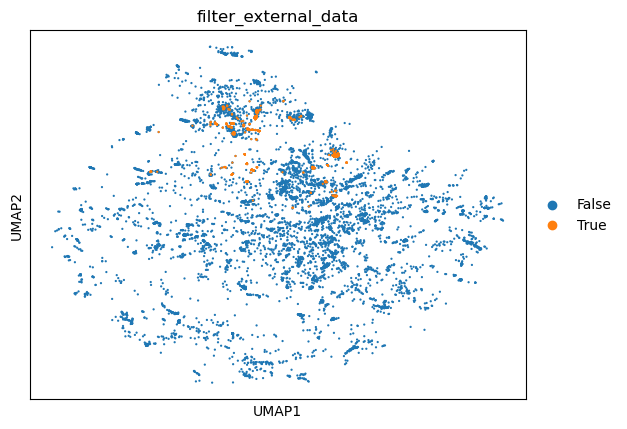

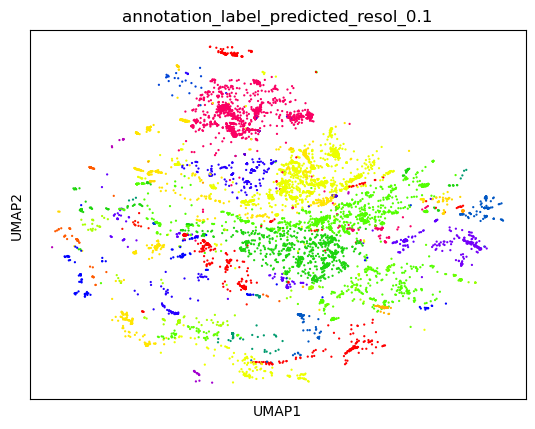

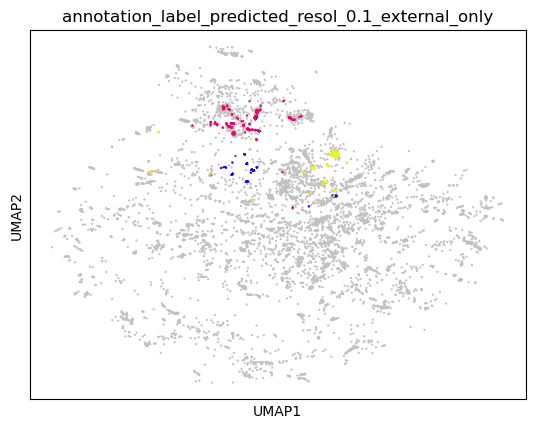

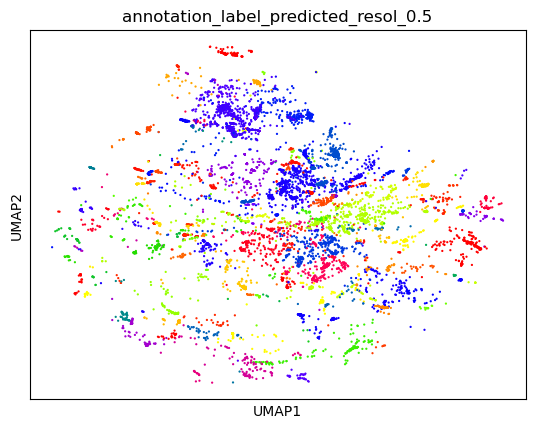

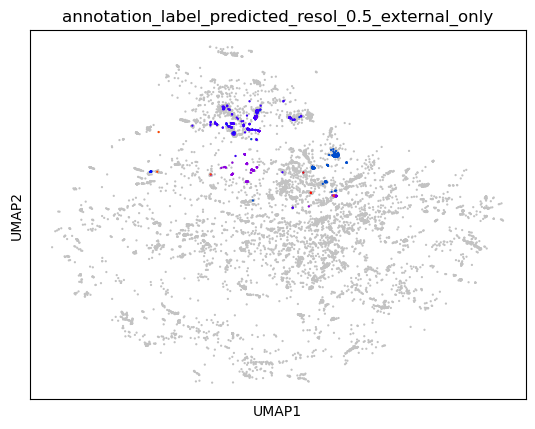

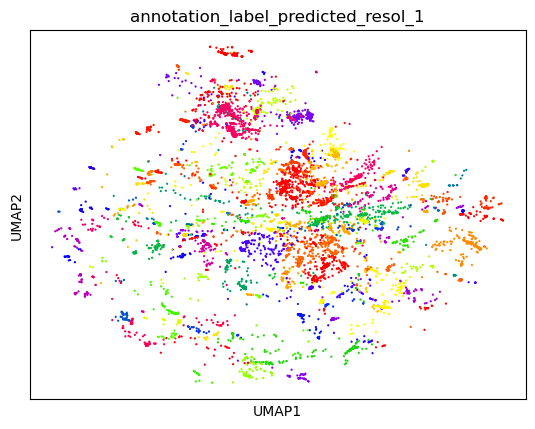

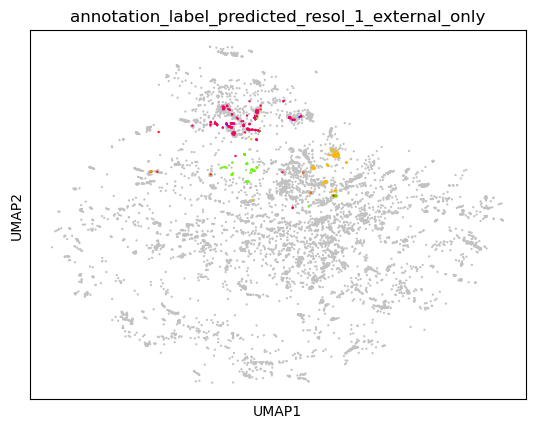

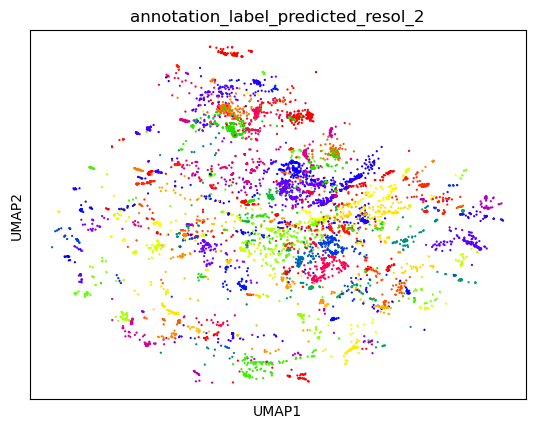

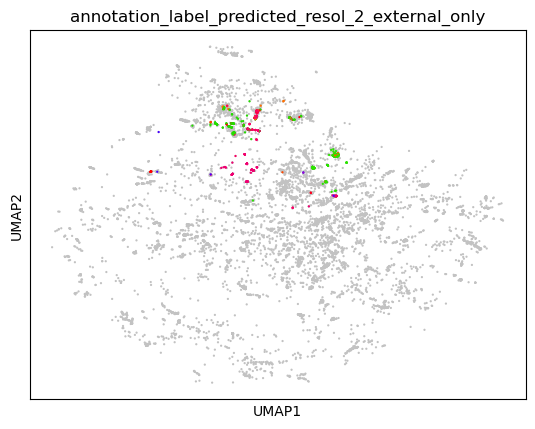

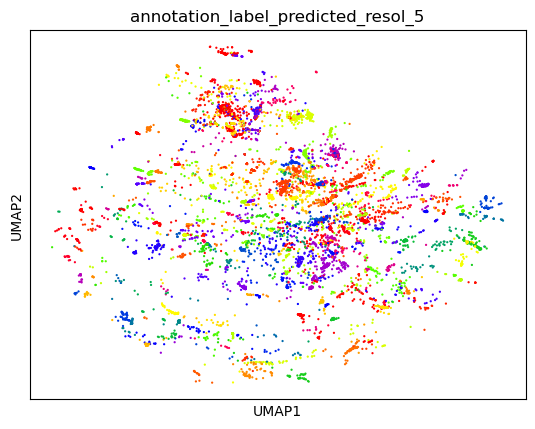

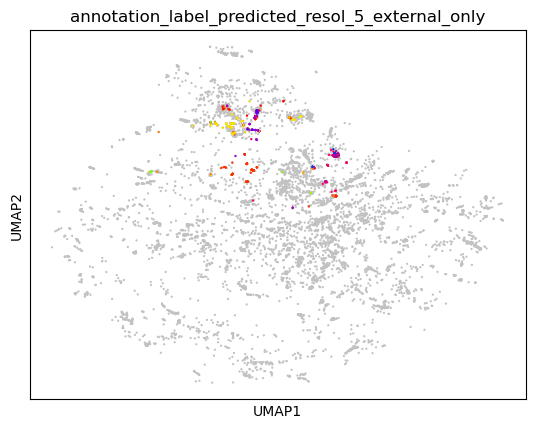

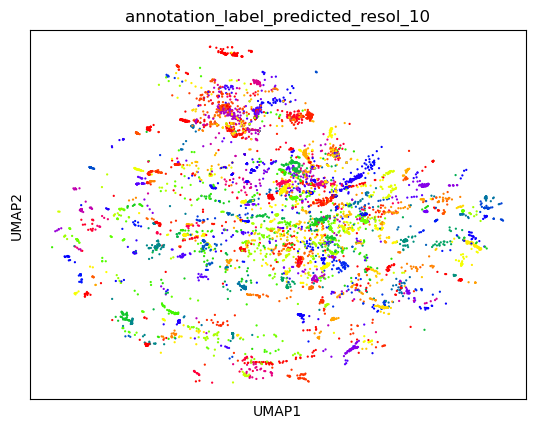

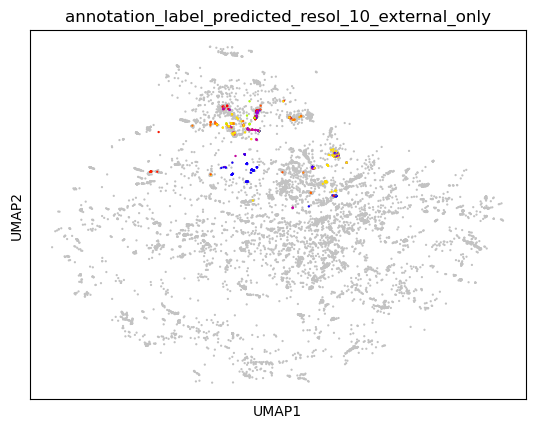

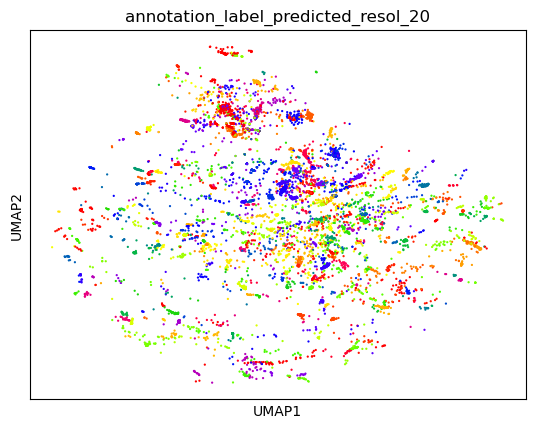

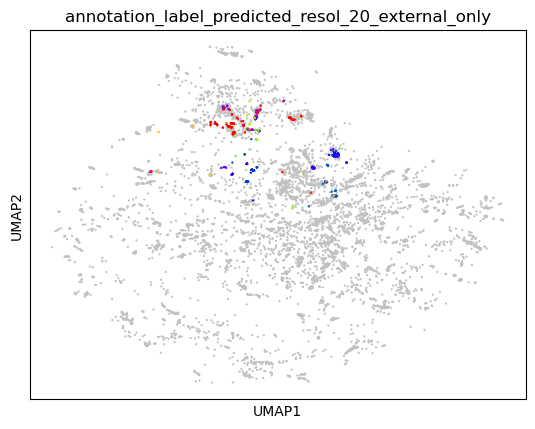

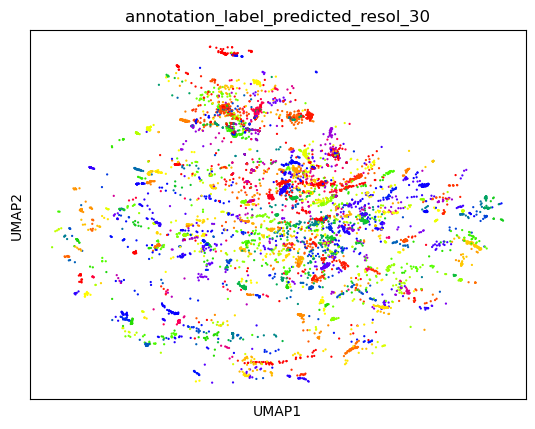

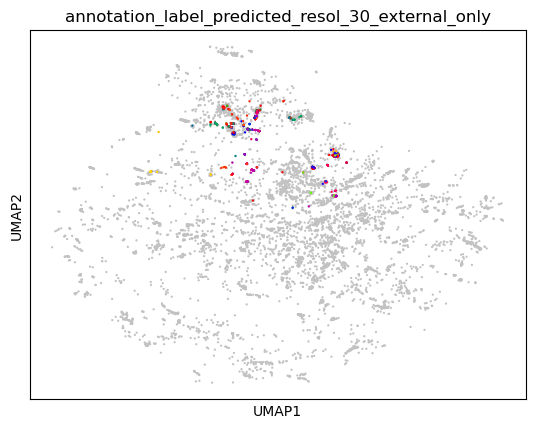

In [10]:
'''
set filter of the external data (dataset of interest)
'''
# set filter
ram.bc.filter = ( ram.bc.select_component( 0 ) & ram.bc.get_filter( f'filtered_barcodes_subsampled_{str_num_subsampled_cells}_entries_clus_info' ) ) | ( ram.bc.select_component( 1 ) & ram.bc.get_filter( name_col_bc_all ) )

ram.ft.load_str( )

# save as a filter
ram.bc.save_as_filter(
    ram.bc.select_component( 1 ) & ram.bc.get_filter( name_col_bc_all ),
    'filter_external_data'
)

"""
plot co-embedded cells
"""
# set filter
ram.bc.filter = ( ram.bc.select_component( 0 ) & ram.bc.get_filter( 'filtered_barcodes_subsampled_160000_entries_clus_info' ) ) | ( ram.bc.select_component( 1 ) & ram.bc.get_filter( name_col_bc_all ) )

adata = ram[ 
    'normalized_log1p_capped', 
    :, 
    [ "str", 'raw_sum', 'filter_external_data', { name_umap_combined } ] + l_anno_ori + list( f'annotation_label_predicted_resol_{resol}' for resol in [ 0.1, 0.5, 1, 2, 5, 10, 20, 30 ] ), 
    ['ACTA2', 'COL1A1', 'TAGLN', 'MYL9', 'COX4I2', 'MKI67', 'CDH5', 'SRGN', 'ACTC1', 'SPP1', 'VCAM1', 'PLCB4', 'KRT19', 'MSI2', 'COLEC11', 'SGIP1', 'MMP11', 'APOA2', 'FLT1', 'POU5F1', 'KRT19', 'COL4A2', 'POSTN', 'CCL19', 'CCL21'], 
    [ 'str' ]
]
adata.obsm[ 'X_umap' ] = adata.obsm[ name_umap_combined ]
adata.obs[ 'filter_external_data' ] = adata.obs[ 'filter_external_data' ].astype( str ).astype( object )
    
sc.pl.umap( adata, color = 'filter_external_data' )

"""
plot predicted annotations
"""
for resol in [ 0.1, 0.5, 1, 2, 5, 10, 20, 30 ] :
    name_anno_combined = f'annotation_label_predicted_resol_{resol}'
    name_anno = f'annotated_leiden_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_filtered_barcodes_subsampled_10857942_entries_30knn100comp_scanpy__resolution_{resol}_based_on_cellmarker2db'
    try :
        adata.obs[ name_anno_combined ] = adata.obs[ name_anno_combined ].cat.add_categories( 'NA' )
    except :
        pass
    sc.pl.umap( adata, color = name_anno_combined, palette = 'prism', legend_loc = None )
    
    adata.obs[ f"{name_anno_combined}_external_only" ] = adata.obs[ name_anno_combined ]
    adata.obs.loc[ adata.obs[ 'filter_external_data' ].values == 'False', f"{name_anno_combined}_external_only" ] = 'NA'
    adata.uns[ f'{name_anno_combined}_external_only_colors' ] = adata.uns[ f'{name_anno_combined}_colors' ]
    adata.uns[ f'{name_anno_combined}_external_only_colors' ][ - 1 ] = '#c2c2c2'
    sc.pl.umap( adata, color = f"{name_anno_combined}_external_only", legend_loc = None )

In [11]:
"""
compare annotations
"""
def Shankey_Compare_Annotations( l_anno_1, l_anno_2, int_min_num_entries_for_an_overlap : int = 3, flag_show_label : bool = True, font_size : int = 10, title : str = '', color = 'blue' ) :
    """ # 2023-03-05 16:32:49 
    draw a Shankey diagram using Plotly for the given lists of annotations
    
    l_anno_1 # first list of annotations 
    l_anno_2 # second list of annotations 
    int_min_num_entries_for_an_overlap : int = 3 # the minmum number of entries for a link (overlaps between two annotations) to be valid.
    title : Union[ None, str ] = None # the name of the figure. if None is given, no title will be shown
    font_size : int = 10, # the font size of the title
    color = 'blue' # argument for plotly.graph_objects.Sankey
    """
    import numpy as np
    def _map( arr_anno, start_pos : int = 0 ) :
        """
        return a dictionary for mapping annotation to its integer representation and a list of unique annotation labels
        """
        l_anno_unique = el.bk.LIST_COUNT( arr_anno, duplicate_filter = None ).index.values # retrieve a list of unique annotations
        return dict( ( e, i + start_pos ) for i, e in enumerate( l_anno_unique ) ), l_anno_unique

    dict_map_1, arr_anno_unique_1 = _map( l_anno_1, start_pos = 0 )
    dict_map_2, arr_anno_unique_2 = _map( l_anno_2, start_pos = len( dict_map_1 ) )
    label = list( arr_anno_unique_1 ) + list( arr_anno_unique_2 ) if flag_show_label else None # compose a list of unique labels # does not show labels if 'flag_show_label' is False

    # retrieve values for drawing the diagram
    source, target, value = el.bk.LIST_COUNT( np.array( [ list( dict_map_1[ e ] for e in l_anno_1 ), list( dict_map_2[ e ] for e in l_anno_2 ) ], dtype = int ).T, duplicate_filter = int_min_num_entries_for_an_overlap ).reset_index( drop = False ).values.T
    # compose a dataframe
    
    # draw a plot
    import plotly.graph_objects as go

    fig = go.Figure( data = [ go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict( color = "black", width = 0.5 ),
          label = label,
          color = color
        ),
        link = dict(
          source = source, 
          target = target,
          value = value
      ))])
    if title is not None :
        fig.update_layout( title_text = title, font_size = font_size )
    return fig

# define the folder containing the data
path_folder = '/home/project/Single_Cell_Full_Length_Atlas/data/pipeline/20211116_ouroboros_short_read_public_data_mining/public_data/no_scarab/scelephant_alignment/pbmc3k/'
path_folder_graph = f'{path_folder}graph/'

name_anno_ori = l_anno_ori[ 0 ] # name of the columns containing original annotations
for resol in [ 0.1, 0.5, 1, 2, 5, 10, 20, 30 ] :
    name_anno_combined = f'annotation_label_predicted_resol_{resol}'
    name_anno = f'annotated_leiden_filter_normalized_log1p_for_embedding_10504_features_normalized_log1p_capped_100comp_filtered_barcodes_subsampled_10857942_entries_30knn100comp_scanpy__resolution_{resol}_based_on_cellmarker2db'
    
    l_anno_1, l_anno_2 = adata.obs.loc[ adata.obs[ 'filter_external_data' ] == 'True', [ name_anno_ori, name_anno_combined ] ].values.T
    fig = Shankey_Compare_Annotations( l_anno_1, l_anno_2, int_min_num_entries_for_an_overlap = 20, flag_show_label = True, title = name_anno_combined )
    fig.show( )
    fig.write_html( f"{path_folder_graph}plotly.shankey_comparison.{name_anno_ori}.{name_anno_combined}.html" )